### in this notebook we'll convert a pytorch model to a tensorflow model

source: [kaggle link](https://www.kaggle.com/mikeb62/converting-pytorch-model-to-tensorflow-2-2-0)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import random_split
import os

In [3]:
import cv2

### load the pytorch model

In [4]:
class Vgg(nn.Module):
    def __init__(self, drop=0.2):
        super().__init__()

        self.conv1a = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding=1)
        self.conv1b = nn.Conv2d(64, out_channels=64, kernel_size=3, padding=1)

        self.conv2a = nn.Conv2d(64, 128, 3, padding=1)
        self.conv2b = nn.Conv2d(128, 128, 3, padding=1)

        self.conv3a = nn.Conv2d(128, 256, 3, padding=1)
        self.conv3b = nn.Conv2d(256, 256, 3, padding=1)

        self.conv4a = nn.Conv2d(256, 512, 3, padding=1)
        self.conv4b = nn.Conv2d(512, 512, 3, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bn1a = nn.BatchNorm2d(64)
        self.bn1b = nn.BatchNorm2d(64)

        self.bn2a = nn.BatchNorm2d(128)
        self.bn2b = nn.BatchNorm2d(128)

        self.bn3a = nn.BatchNorm2d(256)
        self.bn3b = nn.BatchNorm2d(256)

        self.bn4a = nn.BatchNorm2d(512)
        self.bn4b = nn.BatchNorm2d(512)

        # self.lin1 = nn.Linear(512 * 2 * 2, 4096)
        self.lin1 = nn.Linear(512 * 3 * 3, 4096)
        self.lin2 = nn.Linear(4096, 4096)

        # self.lin3 = nn.Linear(4096, 7)
        # output size changed to 9 because we're using the fer plus labels, not the fer 2013 labels
        self.lin3 = nn.Linear(4096, 9)

        self.drop = nn.Dropout(p=drop)

    def forward(self, x):
        x = F.relu(self.bn1a(self.conv1a(x)))
        x = F.relu(self.bn1b(self.conv1b(x)))
        x = self.pool(x)

        x = F.relu(self.bn2a(self.conv2a(x)))
        x = F.relu(self.bn2b(self.conv2b(x)))
        x = self.pool(x)

        x = F.relu(self.bn3a(self.conv3a(x)))
        x = F.relu(self.bn3b(self.conv3b(x)))
        x = self.pool(x)

        x = F.relu(self.bn4a(self.conv4a(x)))
        x = F.relu(self.bn4b(self.conv4b(x)))
        x = self.pool(x)
        
        # x = x.view(-1, 512 * 2 * 2)
        x = torch.flatten(x, 1)
        x = F.relu(self.drop(self.lin1(x)))
        x = F.relu(self.drop(self.lin2(x)))
        x = self.lin3(x)
        
        return x

In [5]:
model = Vgg()

In [6]:
model

Vgg(
  (conv1a): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1b): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2a): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2b): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3a): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3b): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4a): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4b): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn1a): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn1b): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2a): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn

In [7]:
device = torch.device('cpu')

In [9]:
model.load_state_dict(torch.load('saved_model/finalmodel_state_dict.pth', map_location=device))

<All keys matched successfully>

### convert the pytorch model to onnx 

In [10]:
dummy_input = torch.rand((1,1,48,48), dtype=torch.float32)

In [11]:
dummy_input

tensor([[[[0.5648, 0.9512, 0.1329,  ..., 0.7829, 0.1105, 0.5497],
          [0.2105, 0.7299, 0.0238,  ..., 0.9443, 0.4561, 0.1825],
          [0.4747, 0.2789, 0.3126,  ..., 0.3560, 0.9116, 0.7244],
          ...,
          [0.7264, 0.5932, 0.9075,  ..., 0.0203, 0.0890, 0.6701],
          [0.6627, 0.9333, 0.8102,  ..., 0.9927, 0.8288, 0.8657],
          [0.9836, 0.2909, 0.1166,  ..., 0.7824, 0.2236, 0.7210]]]])

In [12]:
dummy_input.shape

torch.Size([1, 1, 48, 48])

In [13]:
type(dummy_input)

torch.Tensor

In [14]:
torch.onnx.export(model, dummy_input, 'vggnet.onnx', verbose=True)

graph(%input.1 : Float(1, 1, 48, 48, strides=[2304, 2304, 48, 1], requires_grad=0, device=cpu),
      %lin1.weight : Float(4096, 4608, strides=[4608, 1], requires_grad=1, device=cpu),
      %lin1.bias : Float(4096, strides=[1], requires_grad=1, device=cpu),
      %lin2.weight : Float(4096, 4096, strides=[4096, 1], requires_grad=1, device=cpu),
      %lin2.bias : Float(4096, strides=[1], requires_grad=1, device=cpu),
      %lin3.weight : Float(9, 4096, strides=[4096, 1], requires_grad=1, device=cpu),
      %lin3.bias : Float(9, strides=[1], requires_grad=1, device=cpu),
      %98 : Float(64, 1, 3, 3, strides=[9, 9, 3, 1], requires_grad=0, device=cpu),
      %99 : Float(64, strides=[1], requires_grad=0, device=cpu),
      %101 : Float(64, 64, 3, 3, strides=[576, 9, 3, 1], requires_grad=0, device=cpu),
      %102 : Float(64, strides=[1], requires_grad=0, device=cpu),
      %104 : Float(128, 64, 3, 3, strides=[576, 9, 3, 1], requires_grad=0, device=cpu),
      %105 : Float(128, strides=[1]

### save the model in the tensorflow format 

In [20]:
import io
import numpy as np

from torch import nn
import torch.utils.model_zoo as model_zoo
import torch.onnx

import torch.nn as nn
import torch.nn.init as init

import tensorflow as tf
import onnx 
from onnx_tf.backend import prepare

import os
import warnings

AttributeError: module 'tensorflow' has no attribute 'contrib'

#### load the exported onnc model and output a readable view of the graph 

In [11]:
onnx_model = onnx.load('vggnet.onnx')

In [12]:
# check that the IR is well formed
onnx.checker.check_model(onnx_model)

In [13]:
# print a human readable representation of the graph
onnx.helper.printable_graph(onnx_model.graph)

'graph torch-jit-export (\n  %input.1[FLOAT, 1x1x48x48]\n) initializers (\n  %lin1.weight[FLOAT, 4096x4608]\n  %lin1.bias[FLOAT, 4096]\n  %lin2.weight[FLOAT, 4096x4096]\n  %lin2.bias[FLOAT, 4096]\n  %lin3.weight[FLOAT, 9x4096]\n  %lin3.bias[FLOAT, 9]\n  %98[FLOAT, 64x1x3x3]\n  %99[FLOAT, 64]\n  %101[FLOAT, 64x64x3x3]\n  %102[FLOAT, 64]\n  %104[FLOAT, 128x64x3x3]\n  %105[FLOAT, 128]\n  %107[FLOAT, 128x128x3x3]\n  %108[FLOAT, 128]\n  %110[FLOAT, 256x128x3x3]\n  %111[FLOAT, 256]\n  %113[FLOAT, 256x256x3x3]\n  %114[FLOAT, 256]\n  %116[FLOAT, 512x256x3x3]\n  %117[FLOAT, 512]\n  %119[FLOAT, 512x512x3x3]\n  %120[FLOAT, 512]\n) {\n  %97 = Conv[dilations = [1, 1], group = 1, kernel_shape = [3, 3], pads = [1, 1, 1, 1], strides = [1, 1]](%input.1, %98, %99)\n  %65 = Relu(%97)\n  %100 = Conv[dilations = [1, 1], group = 1, kernel_shape = [3, 3], pads = [1, 1, 1, 1], strides = [1, 1]](%65, %101, %102)\n  %68 = Relu(%100)\n  %69 = MaxPool[kernel_shape = [2, 2], pads = [0, 0, 0, 0], strides = [2, 2]](

#### make sure you're using the right version of tensorflow

In [14]:
import warnings

In [15]:
print(tf.version.VERSION)

2.4.1


In [16]:
# ignore all warning messages from tensorflow
warnings.filterwarnings('ignore')

# import the onnx model to tensorflow
tf_rep = prepare(onnx_model)

# export the .pb file
tf_rep.export_graph("vggnet.pb")

NameError: name 'prepare' is not defined

### load the tensorflow model and test it

In [61]:
tfmodel = tf.saved_model.load('vggnet.pb', tags=None)

In [62]:
tfmodel

<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject at 0x7f8afe3a7f10>

#### prepare a test input

In [63]:
testimage = cv2.imread('surprise.jpg')

In [64]:
testimage.shape

(266, 300, 3)

In [41]:
type(testimage)

numpy.ndarray

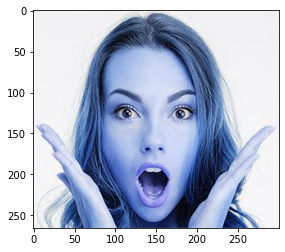

In [43]:
plt.imshow(testimage)

In [44]:
testimage = cv2.cvtColor(testimage, cv2.COLOR_BGR2GRAY)

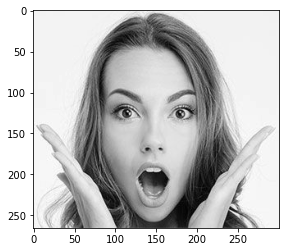

In [46]:
plt.imshow(testimage, cmap='gray')

In [47]:
testimage = cv2.resize(testimage, (48,48))

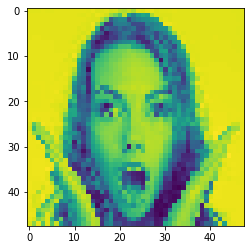

In [48]:
plt.imshow(testimage)

In [49]:
testimage.shape

(48, 48)

In [50]:
testimagetensor = tf.convert_to_tensor(testimage, dtype=tf.float32)

In [51]:
testimagetensor

<tf.Tensor: shape=(48, 48), dtype=float32, numpy=
array([[242., 242., 242., ..., 241., 241., 241.],
       [243., 243., 243., ..., 242., 241., 241.],
       [243., 243., 243., ..., 242., 241., 241.],
       ...,
       [247., 246., 173., ..., 246., 246., 246.],
       [245., 239., 207., ..., 246., 246., 246.],
       [239., 209., 245., ..., 244., 246., 246.]], dtype=float32)>

In [52]:
testimagetensor = tf.expand_dims(testimagetensor, 0)
testimagetensor = tf.expand_dims(testimagetensor, 0)

In [65]:
testimagetensor.shape

TensorShape([1, 1, 48, 48])

### let's test the onnx model imported into tensorflow

In [73]:
tf_rep.run(testimagetensor)

Outputs(_0=array([[ 0.3429988 , -1.2749306 ,  4.70522   , -1.5999409 , -1.4939694 ,
        -3.524343  ,  1.8275441 , -3.6994216 , -0.55610824]],
      dtype=float32))

great! that worked. the model correctly predicted 'surprise'

['neutral',
 'happiness',
 'surprise',
 'sadness',
 'anger',
 'disgust',
 'fear',
 'contempt',
 'unknown']

### now let's test the saved tensorflow model

In [98]:
type(tfmodel)

tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject

In [94]:
inference = tfmodel.signatures["serving_default"]

In [95]:
inference

<ConcreteFunction signature_wrapper(*, input.1) at 0x7F8AFDD79370>

In [96]:
tfpred = inference(testimagetensor)

In [97]:
tfpred

{'96': <tf.Tensor: shape=(1, 9), dtype=float32, numpy=
 array([[ 0.3429988 , -1.2749306 ,  4.70522   , -1.5999409 , -1.4939694 ,
         -3.524343  ,  1.8275441 , -3.6994216 , -0.55610824]],
       dtype=float32)>}

####  awesome! the saved tensorflow .pb model works too. notice that the prediction is not run on the loaded model itself, but on 'inference'  

### Note!

On further research, it looks like the model was saved as a frozen graph, but a SavedModel format is much better.

resources: 
* [github](https://github.com/onnx/onnx-tensorflow/issues/682)
* [stackoverflow](https://stackoverflow.com/questions/44329185/convert-a-graph-proto-pb-pbtxt-to-a-savedmodel-for-use-in-tensorflow-serving-o/44329200#44329200)

but on reading the comment from the github link, it looks like it was a 'saved model' after all?   
comment: @HaoYang0123 We have updated our code base to produce a TF saved model. Both API export_graph and CLI convert will produce a saved model for you.

### convert the tensorflow model to a tfjs model

NOTE: after testing it looks like the model was in a 'savedmodel' format after all

the instructions in [this](https://github.com/tensorflow/tfjs/tree/master/tfjs-converter) github repo was used to successfully convert the tensorflow model to a tfjs model

note that a new environment should be made to install python 3.6.8, and tensorflowjs[wizard]

the model was loaded in inde.html as follows (it is a graph model, not a layers model)

In [ ]:
tf.ready().then(() => {
    const modelpath = 'tfjsmodel/model.json';
    tf.tidy(() => { 
            tf.loadGraphModel(modelpath).then((model) => {